In [ ]:
# Notebook to read in the nexus files and try to smear the electron clouds from the MV hits
import os
import sys
import tables as tb
import numpy  as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import re
from collections import Counter
sys.path.append("../scripts")
from TrackReconstruction_functions import *

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

SyntaxError: invalid syntax (2894448379.py, line 11)

In [122]:
# Load in the hits
# hits = pd.read_hdf(f"../config/NextTonScale_Bi_ion.h5", 'MC/hits')
# parts = pd.read_hdf(f"../config/NextTonScale_Bi_ion.h5", 'MC/particles')

hits = pd.read_hdf(f"../data/ATPC_0nubb/ATPC_0nubb_25bar_nexus_2638.h5", 'MC/hits')
parts = pd.read_hdf(f"../data/ATPC_0nubb/ATPC_0nubb_25bar_nexus_2638.h5", 'MC/particles')


# hits = pd.DataFrame({"event_id":[0], "x": [0], "y": [0], "z": [0], "time":[0], "energy": [10], "particle_id": [0]})
# parts = pd.DataFrame({"event_id":[0], "initial_x": [0], "initial_y": [0], "initial_z": [0], "time":[0], "energy": [1], "particle_id": [0], "particle_name":"e-"})

# hits.z = hits.z+3000
display(hits)

# print(len(hits[hits.event_id ==321959 ]))

,event_id,x,y,z,energy,particle_id,n
0,195286,-253.884949,129.220596,837.404907,0.013795,2,564
1,195286,-253.071869,129.320251,837.881470,0.012589,2,510
2,195286,-252.647629,129.944092,838.453613,0.016133,2,679
3,195286,-252.265778,130.543594,839.077515,0.008185,2,326
4,195286,-251.965973,131.061310,839.809265,0.017097,2,708
...,...,...,...,...,...,...,...
14925,195353,839.222656,140.747284,873.229919,0.003935,1,184
14926,195353,839.218994,140.752487,873.238647,0.007211,1,285
14927,195353,839.218567,140.753494,873.234009,0.002725,1,99
14928,195353,839.216370,140.751541,873.234131,0.003138,1,127


In [123]:
# Define a function to smear the geant4 electrons uniformly between the steps
# Each electron is sampled uniformly towards the previous hit
# The ends of the track are sampled in the backward direction only 
def generate_random(row):
    r0 = np.array([row['x'], row['y'], row['z']])
    r1 = np.array([row['x'] - row['dx'], row['y'] - row['dy'], row['z'] - row['dz']])  # Backward delta

    # Uniformly move backward from the hit by its step size
    random_number = rng.uniform(0, 1)
    new_r = r0 + random_number * (r1 - r0)

    # Apply diffusion if scaling is nonzero
    if diff_scaling != 0.0:
        z = new_r[2]  # mm
        sigma_DL = diff_scaling * DL * np.sqrt(z / 10.0)  # mm  
        sigma_DT = diff_scaling * DT * np.sqrt(z / 10.0)  # mm  

        mean = new_r
        cov = np.diag([sigma_DT**2, sigma_DT**2, sigma_DL**2])  # 3D covariance matrix

        new_r = rng.multivariate_normal(mean, cov)

    return pd.Series(new_r, index=['x_smear', 'y_smear', 'z_smear'])

In [124]:
binsize=1
diff_scaling = 0

percentage = 5

pressure = 25


eid = hits.event_id.unique()[9]

# Scaling by sqrt pressure is applied to convert to whatever pressure at the same E/P
if (percentage == 0.0):
    DL = 0.9 / np.sqrt(pressure) # mm / sqrt(cm)
    DT = 3.5 / np.sqrt(pressure) # mm / sqrt(cm)
elif (percentage == 0.05): # !!HELIUM 10%!!
    DL = 0.75 / np.sqrt(pressure) # mm / sqrt(cm)
    DT = 1.60 / np.sqrt(pressure) # mm / sqrt(cm)
elif (percentage == 0.1):
    DL = 1.037 / np.sqrt(pressure) # mm / sqrt(cm)
    DT = 0.818 / np.sqrt(pressure) # mm / sqrt(cm)
elif (percentage == 0.25):
    DL = 0.627 / np.sqrt(pressure) # mm / sqrt(cm)
    DT = 0.463 / np.sqrt(pressure) # mm / sqrt(cm)
elif (percentage == 5):
    DL = 0.314 / np.sqrt(pressure) # mm / sqrt(cm)
    DT = 0.300 / np.sqrt(pressure) # mm / sqrt(cm)
else:
    print("Error CO2 percentage not defined at 60 V/cm/bar field")

# DL = 1.0 # mm / sqrt(cm)
# DT = 2.0 # mm / sqrt(cm)

density = 5.987*pressure
M = 1000/0.9
det_size = 1000*np.cbrt((4 * M) / (np.pi * density))/2.0
z_shift = det_size

# binsize = round(max(DL, DT)*np.sqrt(2*det_size/10.0))
binsize  = 0.2
print("binsize is:", binsize)

rng = np.random.default_rng()

# Create the bins ---- 
xbw=binsize
xmin=-det_size - binsize/2 
xmax=det_size + binsize/2

ybw=binsize
ymin=-det_size - binsize/2 
ymax=det_size + binsize/2


# This shifts the z pos of the events so 0 is at anode
# can set this to zero
z_shift = det_size
# z_shift = 0

zbw=binsize
zmin=-det_size + z_shift - binsize/2
zmax=det_size + z_shift + binsize/2 

print("Detector size is:", det_size*2)

# bins for x, y, z
xbins = np.arange(xmin, xmax+xbw, xbw)
ybins = np.arange(ymin, ymax+ybw, ybw)
zbins = np.arange(zmin, zmax+zbw, zbw)

# center bins for x, y, z
xbin_c = xbins[:-1] + xbw / 2
ybin_c = ybins[:-1] + ybw / 2
zbin_c = zbins[:-1] + zbw / 2


# Mean energy per e-. This splits up each G4 into E_hit/E_mean electrons
E_mean = 25e-6 # [eV]


binsize is: 0.2
Detector size is: 2114.3300428328175


In [125]:
# Select the event
event = hits[hits.event_id == eid]
event_part = parts[parts.event_id == eid]

# Shift z-values so 0 is at the anode
event.z = event.z+z_shift

# Calc number of electrons in a hit
event["n"] = round(event["energy"]/E_mean)

display(event)
display(event_part)
print(event.energy.sum())
print(event.n.sum())

/var/folders/cf/0fb79lcx5z9by5185swm__x00000gr/T/ipykernel_63137/615838943.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event.z = event.z+z_shift
/var/folders/cf/0fb79lcx5z9by5185swm__x00000gr/T/ipykernel_63137/615838943.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event["n"] = round(event["energy"]/E_mean)


,event_id,x,y,z,energy,particle_id,n
2134,195295,-499.029968,450.231873,1273.818848,0.010656,2,426.0
2135,195295,-499.803650,450.602631,1274.014282,0.013402,2,536.0
2136,195295,-500.637177,450.370300,1274.153442,0.034767,2,1391.0
2137,195295,-501.463562,450.143005,1274.025757,0.017943,2,718.0
2138,195295,-502.132721,449.691986,1273.725830,0.015132,2,605.0
...,...,...,...,...,...,...,...
2308,195295,-488.503601,407.306885,1269.872314,0.000138,6,6.0
2309,195295,-488.503723,407.307312,1269.872314,0.000092,5,4.0
2310,195295,-488.503754,407.308105,1269.872314,0.003096,5,124.0
2311,195295,-488.503693,407.306458,1269.871948,0.000063,4,3.0


,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
415,195295,2,e-,1,0,-498.344696,449.708344,216.285736,0.000000,-505.054321,...,-0.696165,0.756492,0.188485,0.0,-0.0,0.0,0.652433,3.217465e+01,none,eIoni
416,195295,1,e-,1,0,-498.344696,449.708344,216.285736,0.000000,-487.548279,...,1.260288,-1.313954,-1.337824,0.0,-0.0,0.0,1.805398,1.029583e+02,none,eIoni
417,195295,3,gamma,0,1,-488.530914,407.301239,212.719254,0.296342,-488.503601,...,0.007992,0.001646,-0.003524,0.0,0.0,-0.0,0.008888,3.036729e-02,eBrem,phot
418,195295,22,e-,0,3,-488.503601,407.306885,212.707214,0.296443,-488.503601,...,-0.000906,0.001096,0.006697,-0.0,-0.0,0.0,0.000046,3.189086e-05,phot,msc
419,195295,21,e-,0,3,-488.503601,407.306885,212.707214,0.296443,-488.503632,...,-0.003326,0.002149,-0.005646,-0.0,0.0,-0.0,0.000047,7.370703e-05,phot,msc
420,195295,20,e-,0,3,-488.503601,407.306885,212.707214,0.296443,-488.503601,...,0.000953,-0.001079,-0.004352,-0.0,0.0,0.0,0.000021,3.285410e-05,phot,msc
421,195295,19,e-,0,3,-488.503601,407.306885,212.707214,0.296443,-488.503601,...,0.002967,-0.006124,-0.001117,-0.0,-0.0,-0.0,0.000047,1.819991e-05,phot,msc
422,195295,18,e-,0,3,-488.503601,407.306885,212.707214,0.296443,-488.503571,...,0.003652,0.002450,-0.001293,-0.0,0.0,0.0,0.000021,2.104876e-05,phot,msc
423,195295,17,e-,0,3,-488.503601,407.306885,212.707214,0.296443,-488.503601,...,-0.000897,-0.004454,0.004981,0.0,0.0,0.0,0.000044,3.310800e-05,phot,msc
424,195295,16,e-,0,3,-488.503601,407.306885,212.707214,0.296443,-488.503571,...,0.002283,-0.000654,-0.004235,0.0,0.0,-0.0,0.000023,3.471091e-05,phot,msc


2.4578304
98310.0


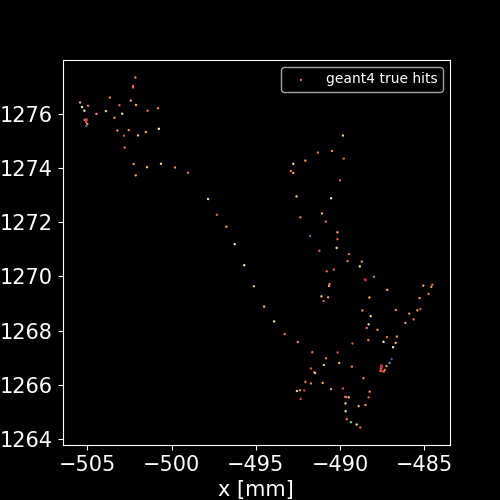

In [126]:
# Plot the event
%matplotlib widget
# Make a 3D view of the track
fig  = plt.figure(figsize=(5, 5))

# event_hits = event_hits[event_hits.particle_id == 579]
# display(event_hits)

# Create 3D axes
ax = fig.add_subplot(111)

fig.set_facecolor('black')
ax.set_facecolor('black')
# ax.scatter(df.x, df.y,  df.z,c= df.energy, cmap='Spectral', s=0.1, label = "reco hits")
ax.scatter(event.x, event.z,c= event.energy, cmap='Spectral', s=0.5, label = "geant4 true hits")

ax.set_xlabel("x [mm]", fontsize = 15)
ax.set_ylabel("y [mm]", fontsize = 15)
# ax.set_zlabel("z [mm]", fontsize = 15)
plt.tick_params(axis='both', which='both', labelsize=15)  # Adjust labelsize as needed

# Set the color of the axes labels and ticks to white
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
# ax.zaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
# ax.tick_params(axis='z', colors='white')

# Set the color of the spines (borders) to white
ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white')
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')


legend = plt.legend(facecolor = "black")

# Set the text color of the legend
for text in legend.get_texts():
    text.set_color('white')  # Set the text color to red

- Sort by particle id
- Sort by time

In [ ]:
df_smear = []


# Loop over the particles and get the differences between steps ------
particles = event.particle_id.unique()

smear_df = []

for idx, p in enumerate(particles):

    # Get hits for particle i in the event
    temp_part_hits = event[event.particle_id == p]
    temp_part = event_part[event_part.particle_id == p]
    particle_name = temp_part.particle_name.iloc[0]

    nrows = len(temp_part_hits)

    # This dataframe contains the difference in distance between hits
    diff_df = temp_part_hits[['x', 'y', 'z']].diff()
    
    diff_df["x"] = diff_df["x"].astype("float64")
    diff_df["y"] = diff_df["y"].astype("float64")
    diff_df["z"] = diff_df["z"].astype("float64")

    # Set the dist for the first hit as the difference to the inital position
    diff_df.iloc[0, diff_df.columns.get_loc('x')] = temp_part_hits.iloc[0].x - temp_part.initial_x.iloc[0]
    diff_df.iloc[0, diff_df.columns.get_loc('y')] = temp_part_hits.iloc[0].y - temp_part.initial_y.iloc[0]
    diff_df.iloc[0, diff_df.columns.get_loc('z')] = temp_part_hits.iloc[0].z - (temp_part.initial_z.iloc[0]+z_shift)
    


    # Name the columns by their deltas
    diff_df = diff_df.rename(columns={'x': 'dx', 'y': 'dy', 'z': 'dz'})

    # We dont want to smear over the gamma steps
    # Only their daughter electrons
    if (particle_name == "gamma"):
        diff_df["dx"] = 0*diff_df["dx"]
        diff_df["dy"] = 0*diff_df["dy"]
        diff_df["dz"] = 0*diff_df["dz"]
    
    smear_df.append(diff_df)

# Concatenate DataFrames along rows (axis=0)
smear_df = pd.concat(smear_df)

# Now merge to the main df
event = pd.merge(event, smear_df, left_index=True, right_index=True, how='inner')

# Create a new DataFrame with duplicated rows, so we can smear each electron by diffusion
electrons = pd.DataFrame(np.repeat(event[["event_id",'x', 'y', 'z', 'dx', 'dy', 'dz']].values, event['n'], axis=0), columns=["event_id",'x', 'y', 'z', 'dx', 'dy', 'dz'])

# Reset the index of the new DataFrame if needed
electrons = electrons.reset_index(drop=True)

# Now apply some smearing to each of the electrons
# Apply the function to create new columns
new_columns     = electrons.apply(generate_random, axis=1)
electrons_smear = pd.concat([electrons, new_columns], axis=1)
electrons_smear["energy"] = E_mean # MeV

# Now lets bin the data
electrons_smear['x'] = pd.cut(x=electrons_smear['x_smear'], bins=xbins,labels=xbin_c, include_lowest=True)
electrons_smear['y'] = pd.cut(x=electrons_smear['y_smear'], bins=ybins,labels=ybin_c, include_lowest=True)
electrons_smear['z'] = pd.cut(x=electrons_smear['z_smear'], bins=zbins,labels=zbin_c, include_lowest=True)

electrons_smear = electrons_smear[["event_id", "x", "y", "z", "energy"]]
electrons_smear = electrons_smear.sort_values(by=['event_id', 'z', 'x', 'y'])

electrons_smear['event_id'] = electrons_smear['event_id'].astype(int)
electrons_smear['z'] = electrons_smear['z'].astype('float32')
electrons_smear['x'] = electrons_smear['x'].astype('float32')
electrons_smear['y'] = electrons_smear['y'].astype('float32')
electrons_smear['energy'] = electrons_smear['energy'].astype('float32')

# Drop any nan numbers. These happen because the smeared hit goes outside the detector active volume
electrons_smear = electrons_smear.dropna()

electrons_smear = (
    electrons_smear.groupby(["event_id", "x", "y", "z"], as_index=False, sort=False)
    .agg({"energy": "sum"})
)

df_smear_merge = electrons_smear.copy()

display(electrons_smear)


1264.4336376770711 1277.3298667712995


,event_id,x,y,z,energy
0,195295,-488.965027,438.434967,1264.400024,0.003100
1,195295,-488.965027,438.634979,1264.400024,0.003725
2,195295,-488.765015,438.634979,1264.400024,0.000625
3,195295,-488.765015,438.834991,1264.400024,0.004700
4,195295,-488.765015,439.034973,1264.400024,0.001500
...,...,...,...,...,...
840,195295,-502.165009,447.034973,1277.199951,0.003200
841,195295,-502.165009,447.234985,1277.199951,0.001800
842,195295,-502.165009,447.434967,1277.199951,0.002825
843,195295,-502.165009,447.634979,1277.199951,0.002050


In [128]:
display(df_smear_merge)
print(df_smear_merge.energy.sum())

,event_id,x,y,z,energy
0,195295,-488.965027,438.434967,1264.400024,0.003100
1,195295,-488.965027,438.634979,1264.400024,0.003725
2,195295,-488.765015,438.634979,1264.400024,0.000625
3,195295,-488.765015,438.834991,1264.400024,0.004700
4,195295,-488.765015,439.034973,1264.400024,0.001500
...,...,...,...,...,...
840,195295,-502.165009,447.034973,1277.199951,0.003200
841,195295,-502.165009,447.234985,1277.199951,0.001800
842,195295,-502.165009,447.434967,1277.199951,0.002825
843,195295,-502.165009,447.634979,1277.199951,0.002050


2.4577498


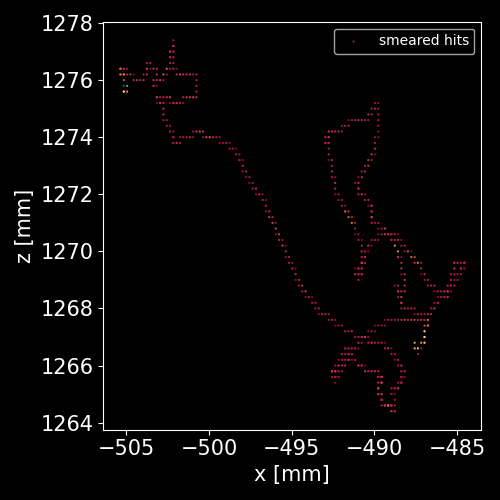

In [129]:
# Plot the event
# Make a 3D view of the track
fig  = plt.figure(figsize=(5, 5))

# event_hits = event_hits[event_hits.particle_id == 579]
# display(event_hits)

# Create 3D axes
ax = fig.add_subplot(111)

fig.set_facecolor('black')
ax.set_facecolor('black')
ax.scatter(df_smear_merge.x, df_smear_merge.z,c= df_smear_merge.energy, cmap='Spectral', s=0.25, label = "smeared hits")
# ax.scatter(df.x, df.z,c= "white", s=1, label = "true hits")

ax.set_xlabel("x [mm]", fontsize = 15)
ax.set_ylabel("z [mm]", fontsize = 15)
# ax.set_zlabel("z [mm]", fontsize = 15)
plt.tick_params(axis='both', which='both', labelsize=15)  # Adjust labelsize as needed

# Set the color of the axes labels and ticks to white
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
# ax.zaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
# ax.tick_params(axis='z', colors='white')

# Set the color of the spines (borders) to white
ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white')
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')

legend = plt.legend(facecolor = "black")

# Set the text color of the legend
for text in legend.get_texts():
    text.set_color('white')  # Set the text color to red

plt.tight_layout()

743


/Users/krishan.mistry/Library/CloudStorage/OneDrive-UTArlington/Code/ATPC/notebooks/TrackReconstruction_functions.py:680: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cut_data["energy"] += cut_data["energy"] / cut_data["energy"].sum() * removed_energy


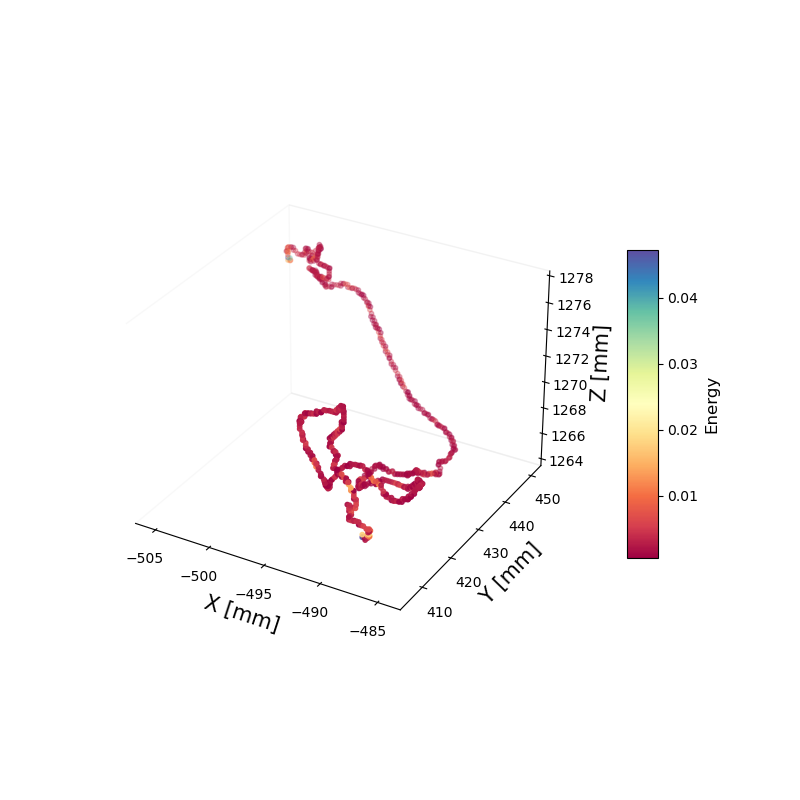

In [130]:
fig = plt.figure(figsize=(8, 8))
# Create 3D axes
ax = fig.add_subplot(111, projection='3d')

fig.set_facecolor('white')
ax.set_facecolor('white')


df_cut = CutandRedistibuteEnergy(df_smear_merge, 0.0005)
print(len(df_cut))

# Scatter plot in 3D
sc = ax.scatter(df_cut.x, df_cut.y, df_cut.z, c=df_cut.energy, cmap='Spectral', s=10, label="Smeared hits")
# sc = ax.scatter(event.x, event.y, event.z, c="k", s=10, label="True hits")

ax.set_xlabel("X [mm]", fontsize=15, color='black')
ax.set_ylabel("Y [mm]", fontsize=15, color='black')
ax.set_zlabel("Z [mm]", fontsize=15, color='black')

# Set the color of the axes labels and ticks to white
ax.xaxis.label.set_color('black')
ax.yaxis.label.set_color('black')
ax.zaxis.label.set_color('black')
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')
ax.tick_params(axis='z', colors='black')
ax.grid(False)

# Add colorbar
cbar = fig.colorbar(sc, ax=ax, shrink=0.5, aspect=10, pad=0.09)
cbar.set_label("Energy", fontsize=12, color='black')
cbar.ax.yaxis.set_tick_params(color='black')
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='black')

# Remove background (axis)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False



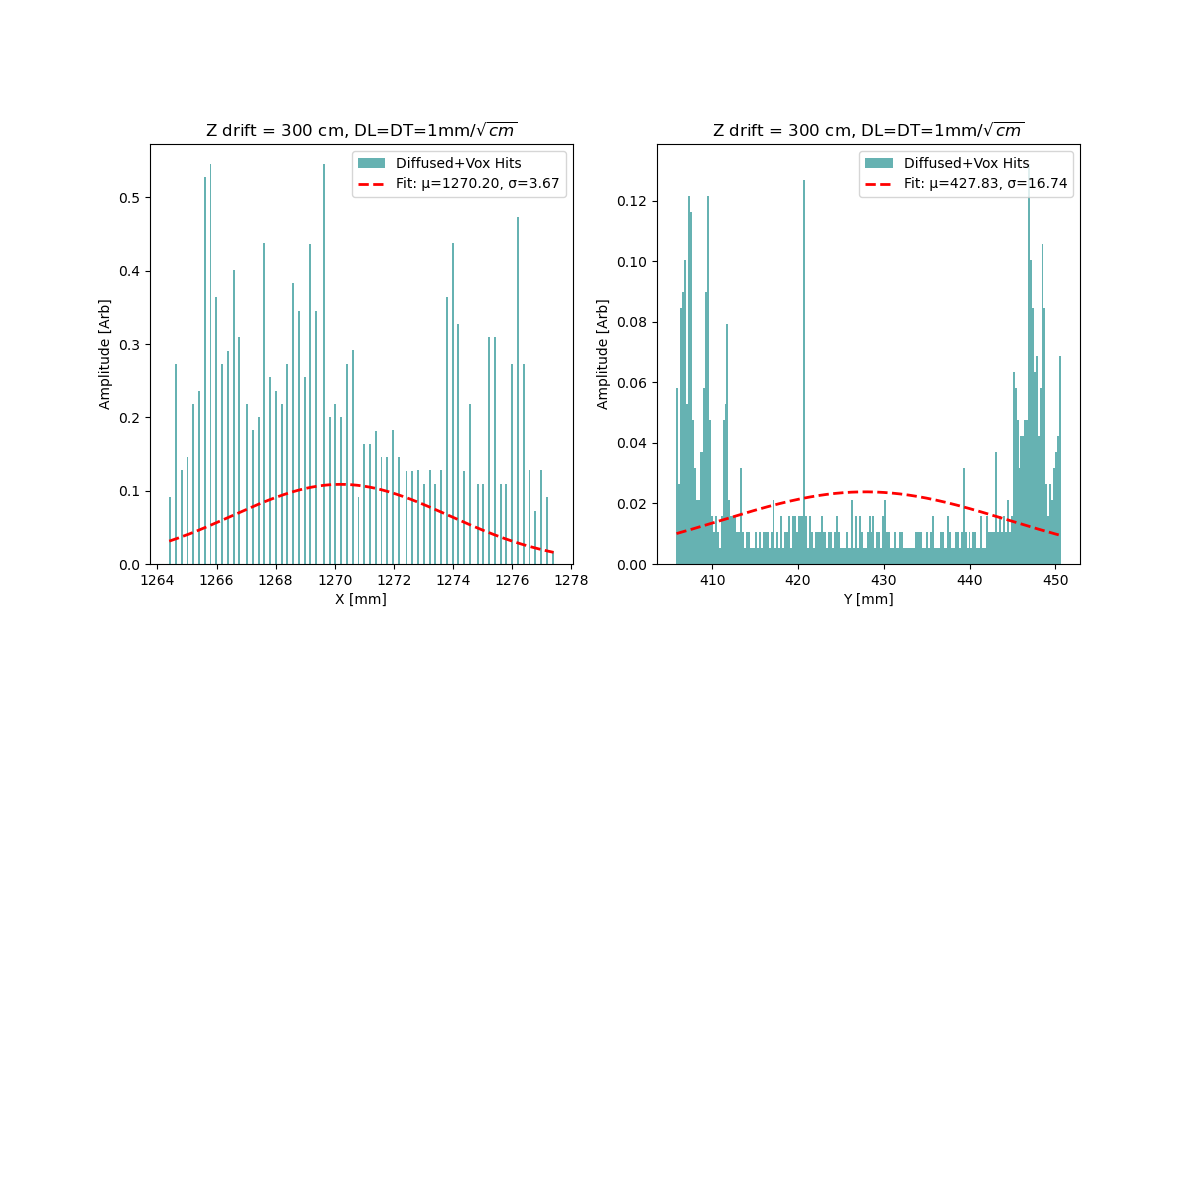

In [131]:
from scipy.stats import norm
fig = plt.figure(figsize=(12,12));

plt.subplot(221);
# Plot histogram
counts, bins, _ = plt.hist(electrons_smear.z, bins=200, density=True, alpha=0.6, color='Teal', label='Diffused+Vox Hits')
mu, sigma = norm.fit(electrons_smear.z)
# counts, bins, _ = plt.hist(test.x_smear, bins=200, density=True, alpha=0.6, color='Teal', label='Diffused Hits')
# mu, sigma = norm.fit(test.x_smear)

# Plot the fitted Gaussian curve
x = np.linspace(bins[0], bins[-1], 1000)
pdf = norm.pdf(x, mu, sigma)
plt.plot(x, pdf, 'r--', linewidth=2, label=f'Fit: μ={mu:.2f}, σ={sigma:.2f}')
plt.xlabel('X [mm]')
plt.ylabel("Amplitude [Arb]")
plt.legend()
plt.title(r"Z drift = 300 cm, DL=DT=1mm/$\sqrt{cm}$")

plt.subplot(222);
# Plot histogram
counts, bins, _ = plt.hist(electrons_smear.y, bins=200, density=True, alpha=0.6, color='Teal', label='Diffused+Vox Hits')
mu, sigma = norm.fit(electrons_smear.y)
# counts, bins, _ = plt.hist(test.y_smear, bins=200, density=True, alpha=0.6, color='Teal', label='Diffused Hits')
# mu, sigma = norm.fit(test.y_smear)
# Plot the fitted Gaussian curve
x = np.linspace(bins[0], bins[-1], 1000)
pdf = norm.pdf(x, mu, sigma)
plt.plot(x, pdf, 'r--', linewidth=2, label=f'Fit: μ={mu:.2f}, σ={sigma:.2f}')
plt.xlabel('Y [mm]')
plt.ylabel("Amplitude [Arb]")
plt.legend()
plt.title(r"Z drift = 300 cm, DL=DT=1mm/$\sqrt{cm}$")


plt.show()





/var/folders/cf/0fb79lcx5z9by5185swm__x00000gr/T/ipykernel_63137/768432054.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["z"] = df["z"]+3000


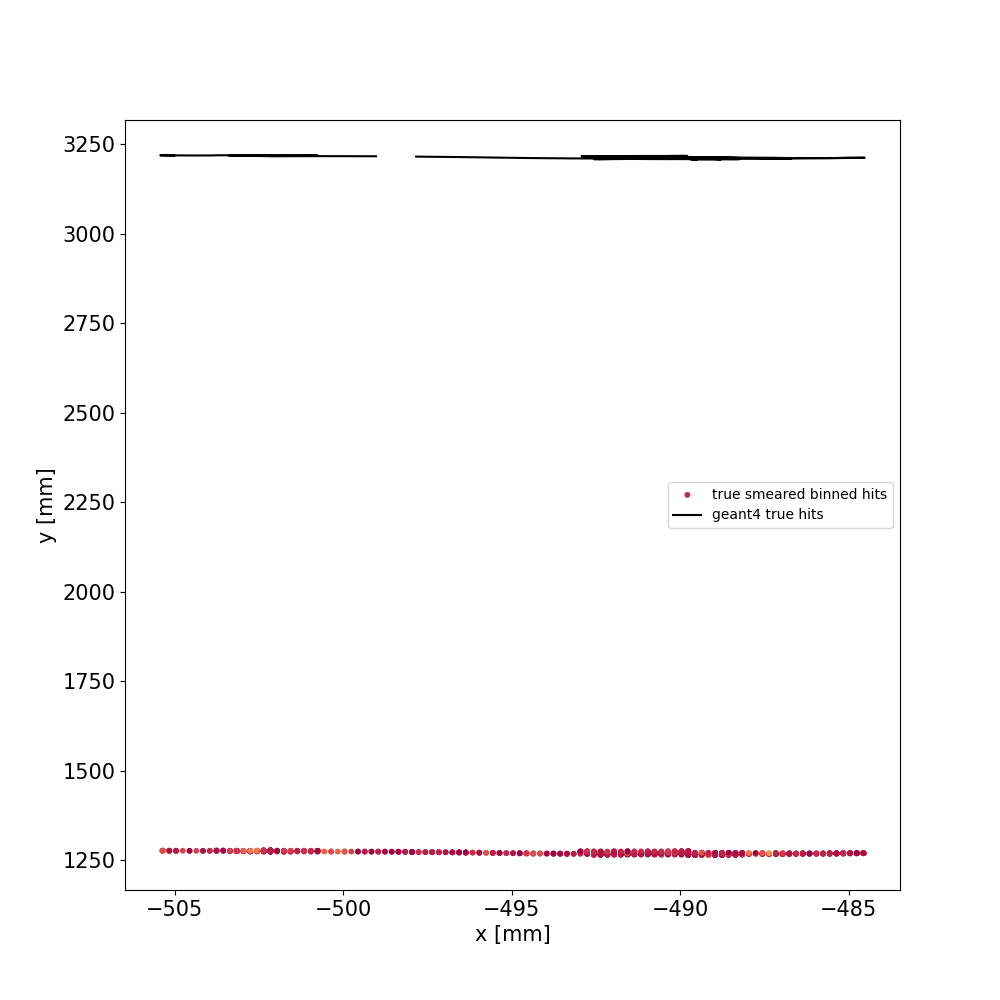

In [132]:
# Plot the event
# Make a 3D view of the track
fig  = plt.figure(figsize=(10, 10))

df = hits[hits.event_id == eid]
df["z"] = df["z"]+3000
# event_hits = event_hits[event_hits.particle_id == 579]
# display(event_hits)

# Create 3D axes
ax = fig.add_subplot(111)

# fig.set_facecolor('black')
# ax.set_facecolor('black')
# df_smear_merge=df_smear_merge[df_smear_merge.energy > 0.0001]
ax.scatter(df_smear_merge.x, df_smear_merge.z,c= df_smear_merge.energy, cmap='Spectral', s=10, label = "true smeared binned hits")
# ax.scatter(event_hits.x, event_hits.z,c= event_hits.energy, cmap='Spectral', s=0.5, label = "geant4 true hits")

for index, p in enumerate(df.particle_id.unique()):
    if (index == 0):
        ax.plot(df[df.particle_id == p].x, df[df.particle_id == p].z,c= "black", label = "geant4 true hits")
    else:
        ax.plot(df[df.particle_id == p].x, df[df.particle_id == p].z,c= "black")

ax.set_xlabel("x [mm]", fontsize = 15)
ax.set_ylabel("y [mm]", fontsize = 15)
# ax.set_zlabel("z [mm]", fontsize = 15)
plt.tick_params(axis='both', which='both', labelsize=15)  # Adjust labelsize as needed

# Set the color of the axes labels and ticks to white
# ax.xaxis.label.set_color('white')
# ax.yaxis.label.set_color('white')
# ax.zaxis.label.set_color('white')
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')
# ax.tick_params(axis='z', colors='white')

# Set the color of the spines (borders) to white
# ax.spines['bottom'].set_color('white')
# ax.spines['top'].set_color('white')
# ax.spines['right'].set_color('white')
# ax.spines['left'].set_color('white')


legend = plt.legend(facecolor = "white")


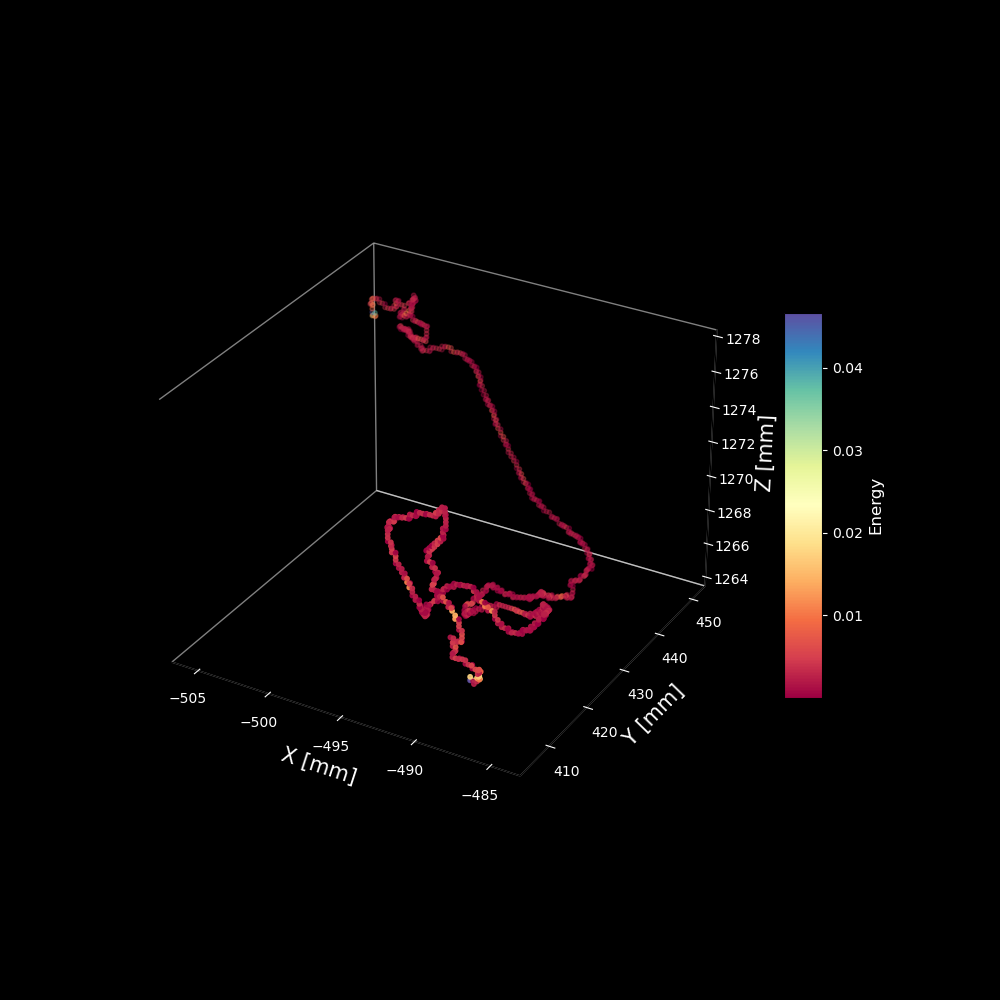

In [133]:
fig  = plt.figure(figsize=(10,10))

# Create 3D axes
ax = fig.add_subplot(111, projection='3d')

fig.set_facecolor('black')
ax.set_facecolor('black')

# Scatter plot in 3D

cut_df = df_smear_merge[df_smear_merge.energy > 0.0000]

sc = ax.scatter(cut_df.x, cut_df.y, cut_df.z, 
                c=cut_df.energy, cmap='Spectral', s=10, label="Reco hits")

ax.set_xlabel("X [mm]", fontsize=15, color='white')
ax.set_ylabel("Y [mm]", fontsize=15, color='white')
ax.set_zlabel("Z [mm]", fontsize=15, color='white')

# Set the color of the axes labels and ticks to white
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.zaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.tick_params(axis='z', colors='white')

# ax.set_title(title, fontsize=15, color='white')

# Set dark theme
ax.xaxis.pane.set_edgecolor("white")
ax.yaxis.pane.set_edgecolor("white")
ax.zaxis.pane.set_edgecolor("white")
ax.grid(False)

# Add colorbar
cbar = fig.colorbar(sc, ax=ax, shrink=0.5, aspect=10)
cbar.set_label("Energy", fontsize=12, color='white')
cbar.ax.yaxis.set_tick_params(color='white')
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='white')

# Remove background (axis)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False